# Prophet Model Forecasting

Prophet Modelling is a time series forecasting model developed by Facebook.
reference is here: https://facebook.github.io/prophet/


In [1]:
!pip install fbprophet
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
import pickle

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### The Model

Here we have a wrapper class that fits the Prophet model according to our pre-set configurations and graphs the appropriate forecast

In [2]:
class ProphetForecast:
    def __init__(self, train, test):
        self.train = train
        self.test = test

    def fit_model(self, n_predict):
        m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
        m.fit(self.train)
        future = m.make_future_dataframe(periods= len(self.test),freq= '1MIN')
        self.forecast = m.predict(future)

        return self.forecast

    def graph(self):
        fig = plt.figure(figsize=(40,10))
        plt.plot(np.array(self.train["ds"]), np.array(self.train["y"]),'b', label="train", linewidth=3)
        plt.plot(np.array(self.test["ds"]), np.array(self.test["y"]), 'g', label="test", linewidth=3)

        forecast_ds = np.array(self.forecast["ds"])
        plt.plot(forecast_ds, np.array(self.forecast["yhat"]), 'o', label="yhat", linewidth=3)
        plt.plot(forecast_ds, np.array(self.forecast["yhat_upper"]), 'y', label="yhat_upper", linewidth=3)
        plt.plot(forecast_ds, np.array(self.forecast["yhat_lower"]), 'y', label="yhat_lower", linewidth=3)
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.legend(loc=1)
        plt.title("Prophet Model Forecast")
        plt.show()

These are basic functions we have been using to reformat counter time series into their differences

In [3]:
def calc_delta(vals):
    diff = vals - np.roll(vals, 1)
    diff[0] = 0
    return diff

def monotonically_inc(vals):
    # check corner case
    if len(vals) == 1:
        return True
    diff = calc_delta(vals)
    diff[np.where(vals == 0)] = 0

    if ((diff < 0).sum() == 0):
        return True
    else:
        return False

#### Load data from Pickle

In [4]:
metric_name = "http_request_duration_microseconds_quantile"
pkl_file = open("data/" + metric_name + "_dataframes.pkl", "rb")
dfs = pickle.load(pkl_file)
pkl_file.close()
key_vals = list(dfs.keys())

#### run Prophet on selected metadata configurations

{'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_instance_type': 'm4.xlarge', 'beta_kubernetes_io_os': 'linux', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'handler': 'prometheus', 'hostname': 'free-stg-node-compute-e0756', 'instance': 'ip-172-31-76-144.us-east-2.compute.internal', 'job': 'kubernetes-nodes-exporter', 'kubernetes_io_hostname': 'ip-172-31-76-144.us-east-2.compute.internal', 'logging_infra_fluentd': 'true', 'node_role_kubernetes_io_compute': 'true', 'quantile': '0.99', 'region': 'us-east-2', 'type': 'compute'}


/home/nfrumkin/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


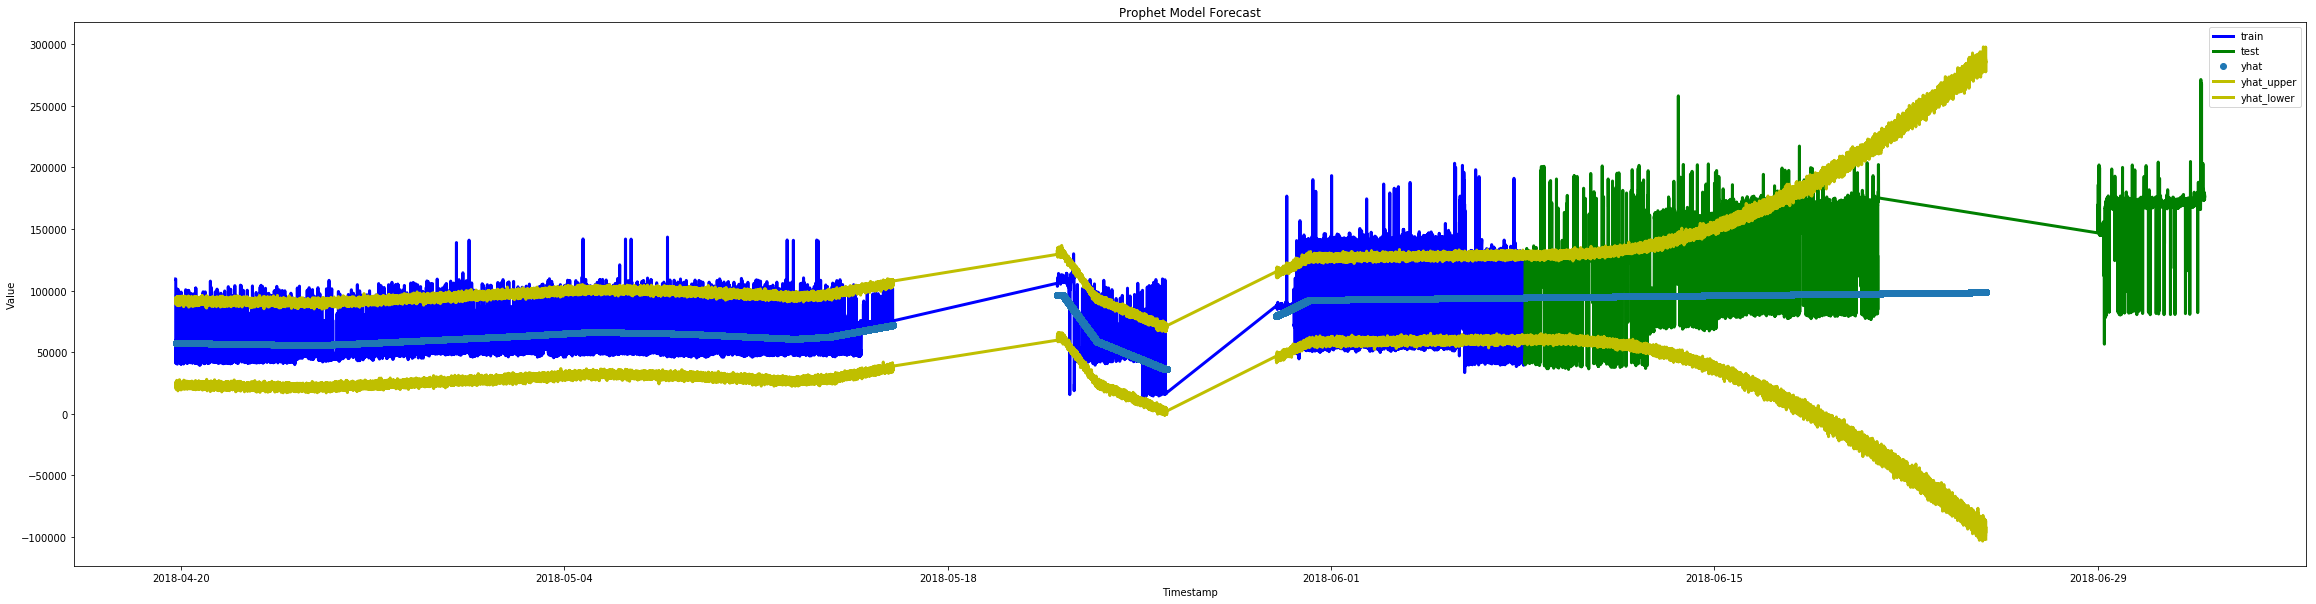

{'__name__': 'http_request_duration_microseconds', 'beta_kubernetes_io_arch': 'amd64', 'beta_kubernetes_io_instance_type': 'm4.xlarge', 'beta_kubernetes_io_os': 'linux', 'failure_domain_beta_kubernetes_io_region': 'us-east-2', 'failure_domain_beta_kubernetes_io_zone': 'us-east-2a', 'handler': 'prometheus', 'instance': 'ip-172-31-67-75.us-east-2.compute.internal', 'job': 'kubernetes-nodes', 'kubernetes_io_hostname': 'ip-172-31-67-75.us-east-2.compute.internal', 'node_role_kubernetes_io_compute': 'true', 'quantile': '0.5', 'region': 'us-east-2', 'runtime': 'cri-o', 'type': 'compute'}


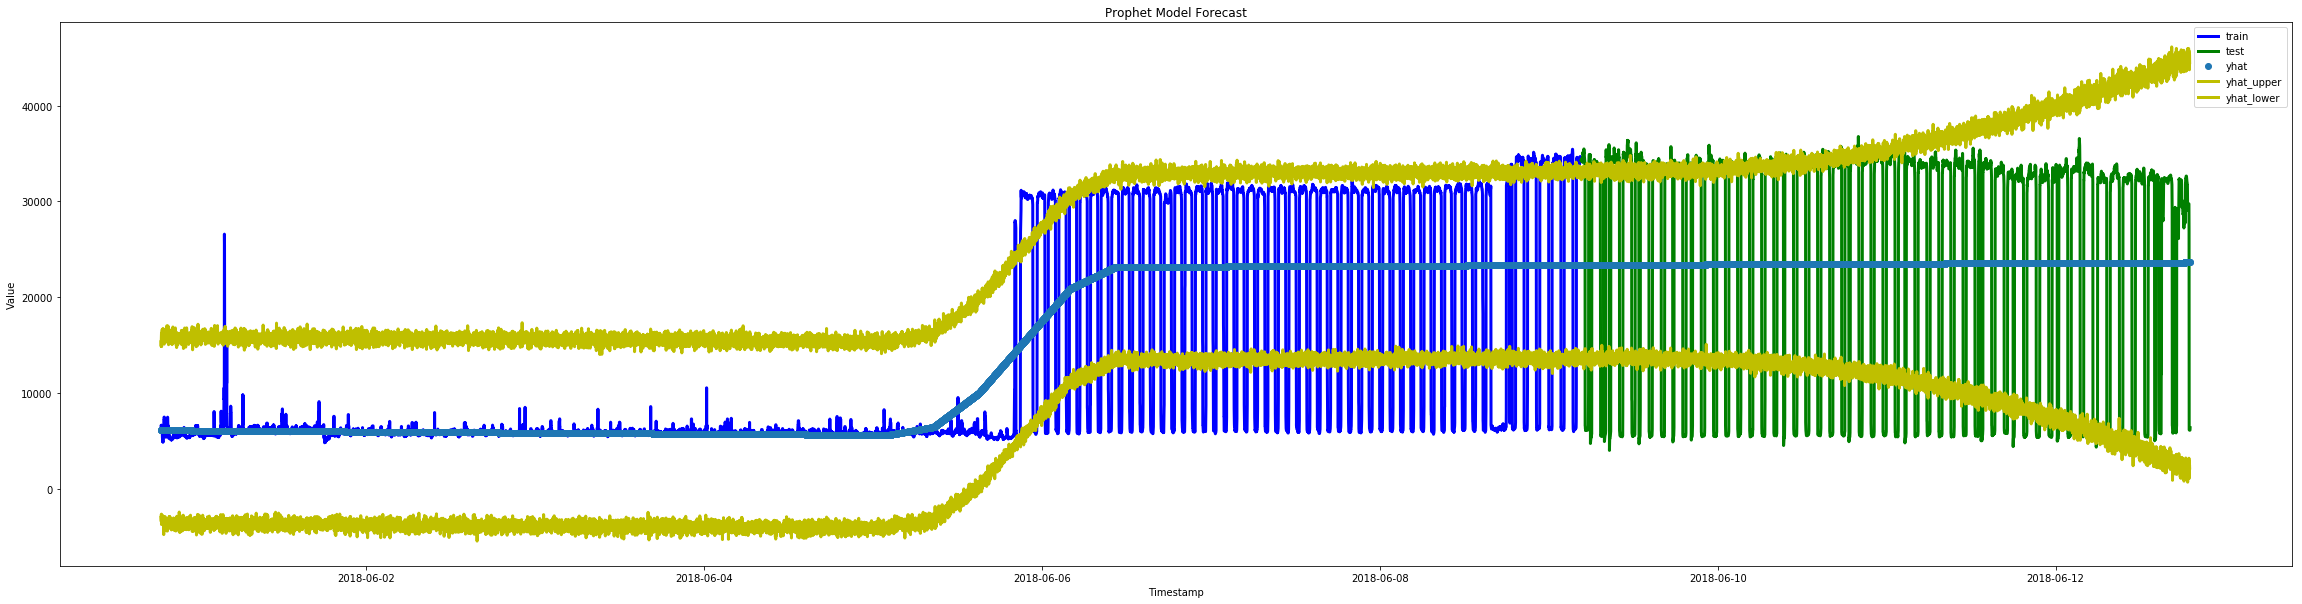

In [5]:
selected = [728,738]
for ind in selected:
    key = key_vals[ind]
    df = dfs[key]
    df = df.sort_values(by=['timestamps'])
    print(key)
    df["values"] = df["values"].apply(pd.to_numeric)
    vals = np.array(df["values"].tolist())

    df["ds"] = df["timestamps"]
    df["y"] = df["values"]
    # check if metric is a counter, if so, run AD on difference
    if monotonically_inc(vals):
        print("monotonically_inc")
        vals = calc_delta(vals)
        df["values"] = vals.tolist()

    train = df[0:int(0.7*len(vals))]
    test = df[int(0.7*len(vals)):]

    pf = ProphetForecast(train, test)
    forecast = pf.fit_model(len(test))

    pf.graph()